In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

### Get the data for cifar10

In [2]:
#get the data

# !mkdir ~/data/cifar10
# !wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz -O ~/data/cifar10/cifar-10-python.tar.gz
# !tar -xvzf cifar-10-python.tar.gz 
# !ln -s ~/data/cifar10/cifar-10-batches-py/ data/


### Imports and Config

In [3]:
import pickle
import time
import numpy as np
import os
from pathlib import Path
from matplotlib import pyplot as plt
import cv2

#imports for SVM classifier
import pandas as pd
from sklearn import svm
from sklearn.model_selection import GridSearchCV


#get fastai libs
from fastai.conv_learner import *
from pretrainedmodels.models.inceptionresnetv2 import inceptionresnetv2
from fastai.model import predict_with_targs

#assign paths
data_path = Path('data/cifar-10-batches-py/')
PATH = Path('data')

### Data load and visualization

In [4]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
        data = dict[b'data']
        labels = np.array(dict[b'labels'])
    return data, labels

def read_to_array(paths, im_shape = (32,32,3)):
    data=[]
    labels=[]
    for file in paths:
        _data, _labels = unpickle(file)
        data.append(_data)
        labels.append(_labels)
    data_all = np.concatenate(data)
    labels_all = np.concatenate(labels)
    im_num, _ = data_all.shape
    data_rsp_ = np.reshape(data_all, (im_num, 32*32,3), order='F')
    data_rsp  = np.reshape(data_rsp_, (im_num, 32,32,3))
    return data_rsp.astype(np.float32) / 255, labels_all.astype(np.int16)
    
train_data, train_label = read_to_array(data_path.glob('data*'))
test_data, test_label = read_to_array(data_path.glob('test*'))
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [5]:
assert(train_data.shape[0]==train_label.shape[0])
assert(test_data.shape[0]==test_label.shape[0])
print(f'Got {train_data.shape[0]} train obs and {test_data.shape[0]} test obs')

Got 50000 train obs and 10000 test obs


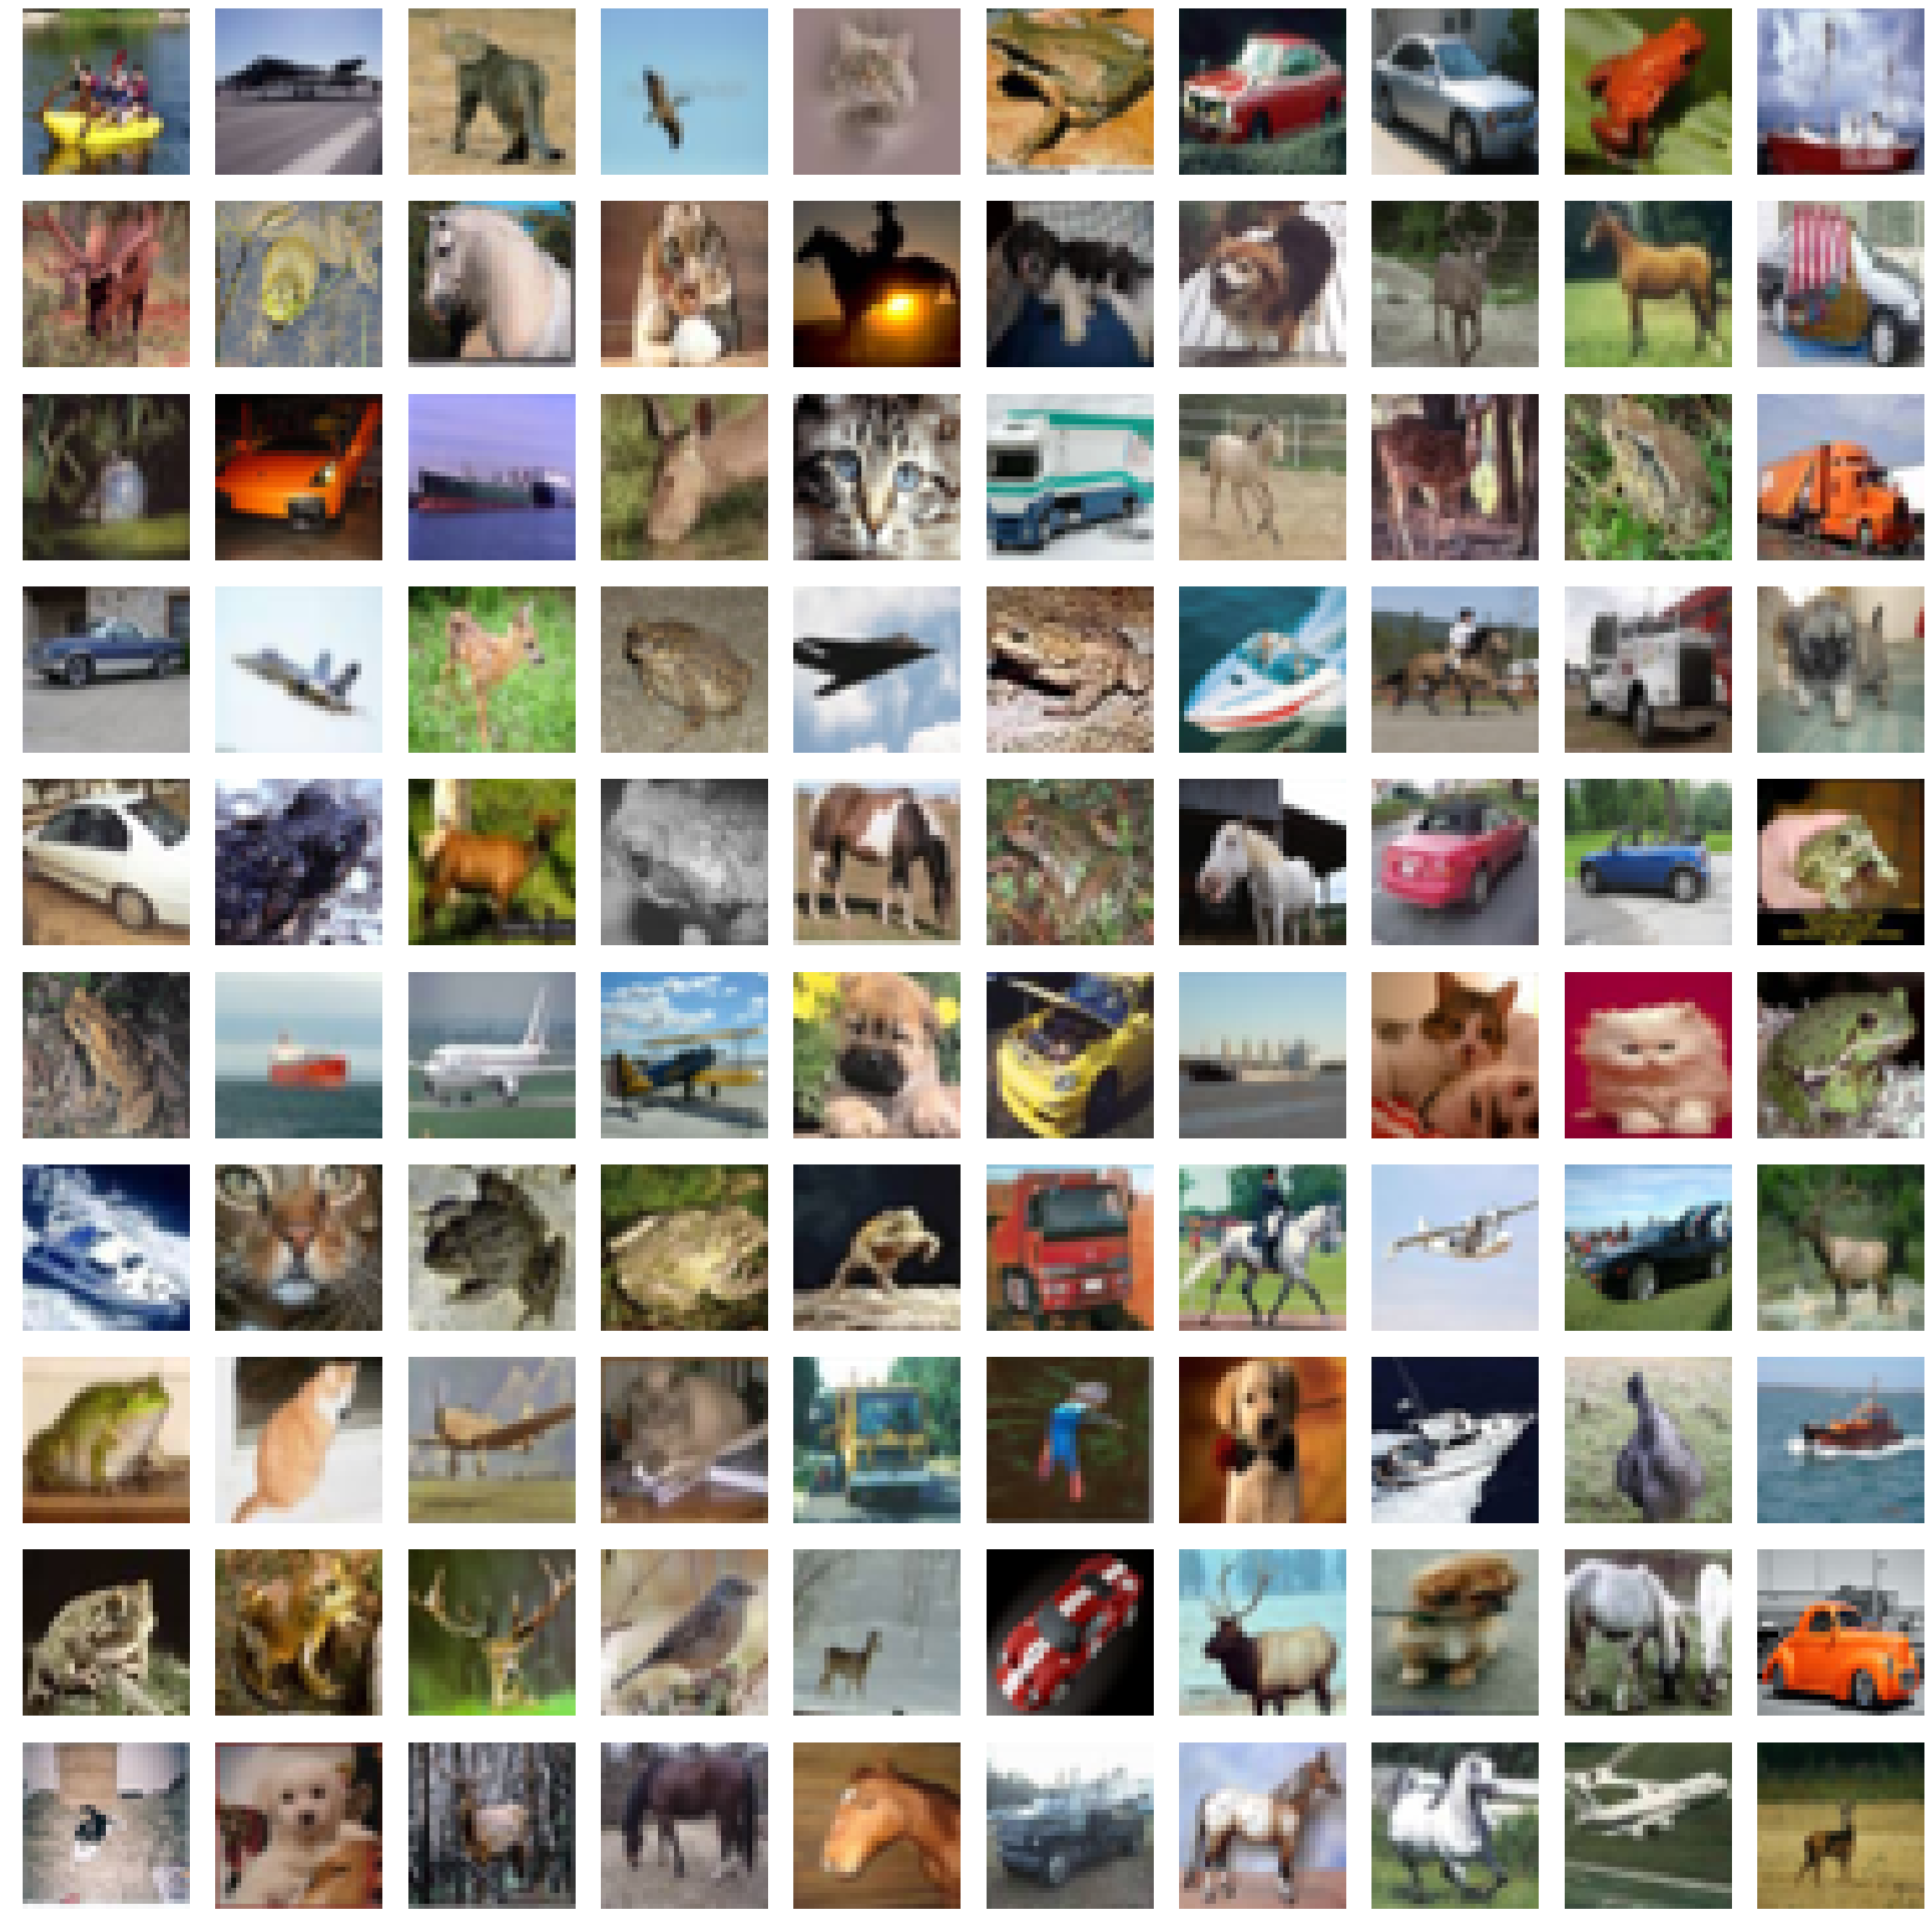

In [6]:
#Draw example images per each class
def draw_10x10(images, labels, classes):
    fig, axis = plt.subplots(10,10,figsize=(32,32))
    for n, cl in enumerate(classes):
        img_idx = np.where(labels==n)[0][:10]
        for m, idx in enumerate(img_idx):
            axis[n,m].imshow(images[idx])
            axis[n,m].axis('off')
        #axis[n,0].set_ylabel(cl, rotation=0, size='large')
    fig.tight_layout()
    plt.show()
    
draw_10x10(train_data, test_label, classes)     


### Train very simple clasifier

This simple classifier will use a features extracted by HOG as the feed for SVM. 
For HOG feature extraction I choose cv2 - it is significantly faster than HOG implementation in skimage

In [44]:
def extract_hog(images):
    ft_list = []
    for img in images:
        img = img*255
        img = img.astype(np.uint8)
        winSize = (32,32)
        blockSize = (16,16)
        blockStride = (8,8)
        cellSize = (8,8)
        nbins = 9
        derivAperture = 1
        winSigma = 4.
        histogramNormType = 0
        L2HysThreshold = 0.2
        gammaCorrection = 0
        nlevels = 64
        hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                                histogramNormType,L2HysThreshold,gammaCorrection,nlevels)
        im_ = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        ft_list.append(hog.compute(im_).flatten())
    return np.stack(ft_list)

In [45]:
# from skimage import feature
# def extract_hog(images):
#     ft_list = []
#     for img in images:
#         im_ = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#         ft_list.append(feature.hog(im_, block_norm = 'L2-Hys'))
#     return np.stack(ft_list)


In [46]:
train_hog_ft = extract_hog(train_data)
test_hog_ft = extract_hog(test_data)

In [47]:
assert(train_data.shape[0]==train_hog_ft.shape[0])
assert(test_data.shape[0]==test_hog_ft.shape[0])
print(f'Hog feature no: {train_hog_ft.shape[1]}')

Hog feature no: 324


For SVM clasifier I am going to use sklearn implementation of Linear SVC which is implemented in liblinear. With 50k obs we have it will be time consuming to use libsvm implementations.

Let's use GridSearch to choose good parameters for clasifier.

In [48]:
tic = time.time()
parameters = {'penalty':['l1', 'l2'], 'C':[0.01,0.1,1,10]}
svc = svm.LinearSVC(dual=False)
clf = GridSearchCV(svc, parameters, n_jobs=8, return_train_score=False)
clf.fit(train_hog_ft, train_label)

toe = time.time()
print(f'Time passed: {toe-tic}')

Time passed: 1141.199793100357


In [49]:
pd.DataFrame(clf.cv_results_)[['mean_fit_time','param_C','param_penalty','mean_test_score','rank_test_score']]

,mean_fit_time,param_C,param_penalty,mean_test_score,rank_test_score
0,90.234639,0.01,l1,0.48148,8
1,23.632061,0.01,l2,0.53360,7
2,421.298734,0.1,l1,0.53430,6
3,31.024014,0.1,l2,0.54226,1
4,697.850788,1,l1,0.54030,4
5,34.305302,1,l2,0.54086,2
6,758.256811,10,l1,0.53864,5
7,38.765568,10,l2,0.54058,3


In [50]:
#looks like l2 regularization is better here and l1 is very time consuming
#for future svm training I will use only l2

In [51]:
#check the best clasifier on the test dataset
test_score = clf.score(test_hog_ft, test_label)
print(f'Score for test data: {test_score}')

Score for test data: 0.5414


### CNN feature extraction - transfer learning

In this step I am going to use model trained on imagenet as a feature extractor for CIFAR10. I am going to use awesome fastai library (very nice toolset build on top of pytorch) and pretrainedmodels library to get cnn architectures which are not yet available in torchvision.models.

I found out that I can get quite good results using inceptionresnetv2 architecure. To use it I am going to download weights trained on imagenet. Then to access second last layer I am just gonna to replace last linear layer with the Identity layer. I could also remove the last layer and build sequential model from remaining ones, but imho it's better to keep oryginal arch class and forward method.

In [52]:
m = inceptionresnetv2(pretrained='imagenet+background', num_classes=1001) # num of is as in the oryginal model

In [53]:
from torch.nn import Module
class IdentityModule(Module):
    def forward(self, inputs):
        return inputs

new_last_linear = IdentityModule()
m.last_linear = new_last_linear

In [54]:
#get the data loader using fastai utils
bs=32
tfms = tfms_from_model(m, sz=299) #model require input 3x299x299
data = ImageClassifierData.from_arrays(PATH, trn=(train_data, train_label), 
                                          val=(test_data, test_label), 
                                          tfms=tfms, bs=bs)

learn = ConvLearner.from_model_data(m, data)

In [55]:
# import torch.utils.model_zoo as model_zoo
# inception_url = 'https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth'
# resnet_url = 'https://download.pytorch.org/models/resnet50-19c8e357.pth'
# inc_res_url = ''
# weigth_dict = model_zoo.load_url(resnet_url)
# #remove from dict the last layer
# weigth_dict.pop('fc.weight')
# weigth_dict.pop('fc.bias')
# # weigth_dict.pop('AuxLogits.fc.weight')
# # weigth_dict.pop('AuxLogits.fc.bias')
# m.load_state_dict(weigth_dict, strict=False)

In [56]:
# get predictions
test_cnn_feat, test_targs = predict_with_targs(m, learn.data.val_dl)
train_cnn_feat, train_targs = predict_with_targs(m, learn.data.trn_dl)

In [57]:
#save in case of kernel crush
np.save('data/tmp/train_cnn.npy',train_cnn_feat)
np.save('data/tmp/train_targs.npy',train_targs)
np.save('data/tmp/test_cnn.npy',test_cnn_feat)
np.save('data/tmp/test_targs.npy',test_targs)



### Visualization of CNN feautres
Very good way for doing this kind of visualizations is approach proposed by A. Karpathy: https://cs.stanford.edu/people/karpathy/cnnembed/
However for small no of classes I think it will be more visible to print labe-colored-points on 2D plot (example: https://medium.com/@luckylwk/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b). I am goind to use unet library as it claims to be much faster than t-sne.


In [58]:
import umap
from sklearn.datasets import fetch_mldata
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context="paper", style="white")

reducer = umap.UMAP(random_state=99)
embedding = reducer.fit_transform(train_cnn_feat)

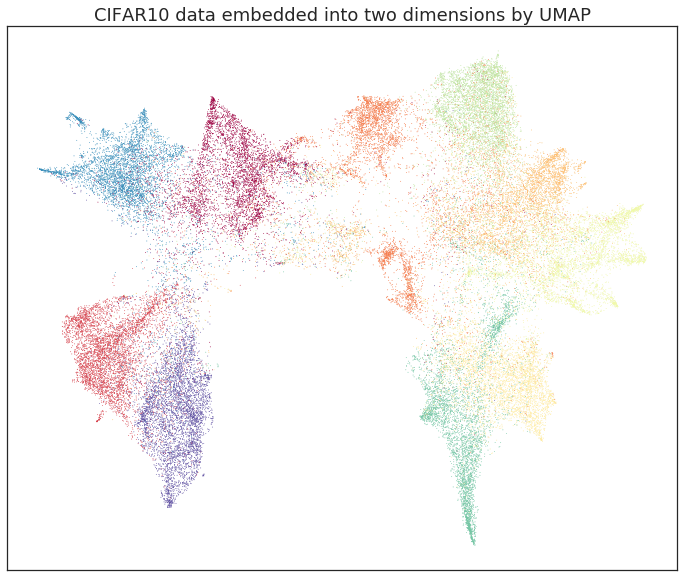

In [59]:
fig, ax = plt.subplots(figsize=(12, 10))
plt.scatter(
    embedding[:, 0], embedding[:, 1], c=train_targs, cmap="Spectral", s=0.3
)
plt.setp(ax, xticks=[], yticks=[])
plt.title("CIFAR10 data embedded into two dimensions by UMAP", fontsize=18)

plt.show()

### Build SVM clasifier on CNN features
As before we use Gridsearch to look for optimal C.


In [60]:
import time
from sklearn import svm
from sklearn.model_selection import GridSearchCV

tic = time.time()
parameters = {'penalty':['l2'], 'C':[0.001,0.01,0.1,1]}
svc = svm.LinearSVC(dual=False)
clf = GridSearchCV(svc, parameters, n_jobs=4, return_train_score=False)
clf.fit(train_cnn_feat, train_targs)

toe = time.time()
print(f'Time passed: {toe-tic}')

Time passed: 316.51897954940796


In [61]:
pd.DataFrame(clf.cv_results_)[['mean_fit_time','param_C','param_penalty','mean_test_score','rank_test_score']]

,mean_fit_time,param_C,param_penalty,mean_test_score,rank_test_score
0,46.252048,0.001,l2,0.88910,3
1,60.729049,0.01,l2,0.89704,1
2,88.273338,0.1,l2,0.89204,2
3,118.282781,1,l2,0.87336,4


Let's check few values around the best parameter

In [62]:
tic = time.time()
parameters = {'penalty':['l2'], 'C':[0.005, 0.0075,0.01,0.025,0.05]}
svc = svm.LinearSVC(dual=False)
clf = GridSearchCV(svc, parameters, n_jobs=5, return_train_score=False)
clf.fit(train_cnn_feat, train_targs)

toe = time.time()
print(f'Time passed: {toe-tic}')

Time passed: 301.1697211265564


In [63]:
pd.DataFrame(clf.cv_results_)[['mean_fit_time','param_C','param_penalty','mean_test_score','rank_test_score']]

,mean_fit_time,param_C,param_penalty,mean_test_score,rank_test_score
0,65.077862,0.005,l2,0.89554,5
1,69.039096,0.0075,l2,0.89604,4
2,73.439157,0.01,l2,0.89704,2
3,84.082181,0.025,l2,0.89726,1
4,85.405300,0.05,l2,0.89628,3


In [64]:
#check the results on the test dataset
test_score = clf.score(test_cnn_feat, test_targs)
print(f'Score for test data: {test_score}')

Score for test data: 0.8998


Not bad. Almost 90% accuracy using transfer learning. Note that CNN model was not trained on CIFAR10.
Probably it's possible to get even better results using libsvn implementations and leveraging non-linear kernels.

### Train CNN model from scratch
For training I was using 1080 Ti with 11GB of memory. Adjust batch size in case of different gpu.

In [ ]:
from fastai.models.cifar10.wideresnet import wrn_22
from fastai.conv_learner import *

# np.mean(train_data, axis=(0,1,2))
# np.std(train_data, axis=(0,1,2))
stats = (np.mean(train_data, axis=(0,1,2)), np.std(train_data, axis=(0,1,2)))

bs=512
sz=32

#as I am not going to do any significant decision based on validation results, I will use test data for validation
tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomCrop(sz), RandomFlip()], pad=sz//8)
data = ImageClassifierData.from_arrays(PATH, trn=(train_data, train_label), 
                                          val=(test_data, test_label), 
                                          tfms=tfms, bs=bs)
m = wrn_22()

learn = ConvLearner.from_model_data(m, data)
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=1e-4

 95%|█████████▍| 93/98 [00:48<00:02,  1.99it/s, loss=6.71]

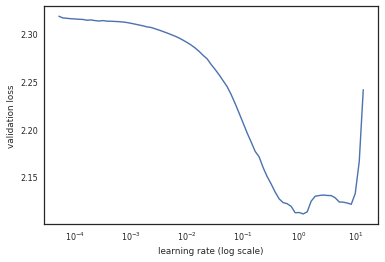

In [82]:
#use lr_find tool to find good candidate for lr
learn.lr_find(end_lr=100, wds=wd)
learn.sched.plot()

In [83]:
lr=1.5

In [84]:
#Leslie Smith's one cycle policy allows to use very high lr
%time learn.fit(lr, 1, wds=wd, cycle_len=30, use_clr_beta=(20,20,0.95,0.85)) 

epoch      trn_loss   val_loss   accuracy                  
    0      1.43531    1.772297   0.4328    
    1      1.041264   1.327685   0.5701                    
    2      0.837128   1.064836   0.6197                    
    3      0.674251   0.715954   0.7519                    
    4      0.560563   0.763457   0.748                     
    5      0.511968   0.5956     0.7932                    
    6      0.451524   0.860039   0.7272                    
    7      0.413012   0.684837   0.7744                    
    8      0.388545   0.887297   0.7567                    
    9      0.367991   0.58919    0.8018                    
    10     0.342812   0.559847   0.8193                    
    11     0.342024   0.618298   0.7937                    
    12     0.326805   0.5391     0.8215                    
    13     0.303158   0.539141   0.829                     
    14     0.281839   0.554723   0.8293                    
    15     0.266906   0.548894   0.828                  

[array([0.22298]), 0.939]

With wideresnet architecture and tweaks of fastai library it's possible to get to 94% accuracy in under 30 minutes of training.

In [85]:
#Try TTA
preds, targs = learn.TTA()

In [86]:
from fastai.metrics import accuracy_np
preds_m = np.average(preds, axis=0)
accuracy_np(preds_m, targs)

0.9441

Using test time augmentation it's possible to get slightly higher and probably more stable results

Let's try different architecture. I tried dpn network which is implemented in https://github.com/kuangliu/pytorch-cifar

In [6]:
from dpn import DPN92
from fastai.conv_learner import *
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

bs=128
sz=32

tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomCrop(sz), RandomFlip()], pad=sz//8)
data = ImageClassifierData.from_arrays(PATH, trn=(train_data, train_label), 
                                          val=(test_data, test_label), 
                                          tfms=tfms, bs=bs)
m = DPN92()

learn = ConvLearner.from_model_data(m, data)
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=1e-4



epoch      trn_loss   val_loss   accuracy                   
    0      2.747459   1.8717081807293608e+21 0.1       



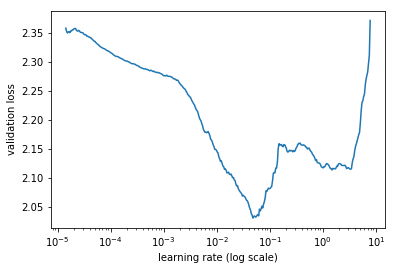

In [7]:
learn.lr_find(wds=wd)
learn.sched.plot()

In [8]:
lr=0.05

In [9]:
%time learn.fit(lr, 1, wds=wd, cycle_len=40, use_clr_beta=(20,20,0.95,0.85))

epoch      trn_loss   val_loss   accuracy                   
    0      1.415036   1.272307   0.5382    
    1      1.094568   1.205639   0.5939                     
    2      0.837313   0.781968   0.7303                      
    3      0.704316   0.812719   0.7237                      
    4      0.599756   0.651438   0.7827                      
    5      0.494674   0.513574   0.8255                      
    6      0.46042    0.489814   0.8358                      
    7      0.419707   0.449636   0.8474                      
    8      0.398753   0.431935   0.8555                      
    9      0.353875   0.415003   0.858                       
    10     0.339554   0.489739   0.8393                      
    11     0.312499   0.388829   0.8721                      
    12     0.277967   0.397473   0.8647                      
    13     0.262577   0.350963   0.886                       
    14     0.250454   0.370742   0.8787                      
    15     0.244923   0.4114

[array([0.32078]), 0.938]

In [10]:
#Try TTA
preds, targs = learn.TTA()
preds_m = np.average(preds, axis=0)
accuracy_np(preds_m, targs)

0.9437